In [440]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [441]:
df = pd.read_csv('../data/SBER_250914_250915.csv', sep=';')

df["date_str"]=df["<DATE>"].apply(lambda x: str(x).zfill(6)).astype(str)
df["time_str"]=df["<TIME>"].apply(lambda x: str(x).zfill(6)).astype(str)
df["datetime_str"]=df["date_str"]+df["time_str"]
df["time_utc"]= pd.to_datetime(df["datetime_str"], format='%y%m%d%H%M%S', utc=True)
df = df.set_index("time_utc")
df.drop(["date_str", "time_str", "datetime_str", "<DATE>", "<TIME>"], axis=1, inplace=True)
df.rename(columns={"<OPEN>": "open", "<HIGH>": "high", "<LOW>": "low", "<CLOSE>": "close", "<VOL>": "volume"}, inplace=True)

df = df.tail(200)

In [442]:
# make stationary
diff_close = np.diff(df["close"], n=1)

ADF_result = adfuller(diff_close)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')


ADF Statistic: -11.364641522468768
p-value: 9.291103856028411e-21


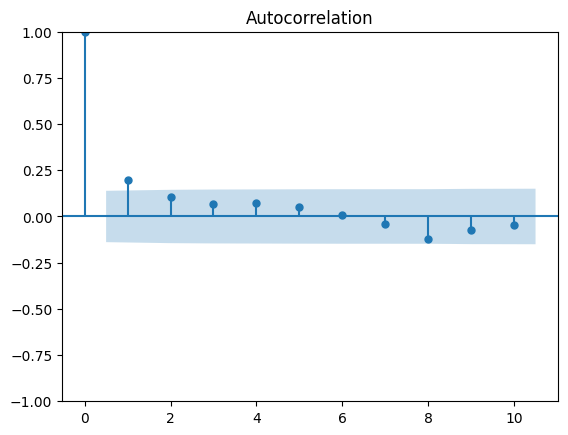

In [443]:
plot_acf(diff_close, lags=10);

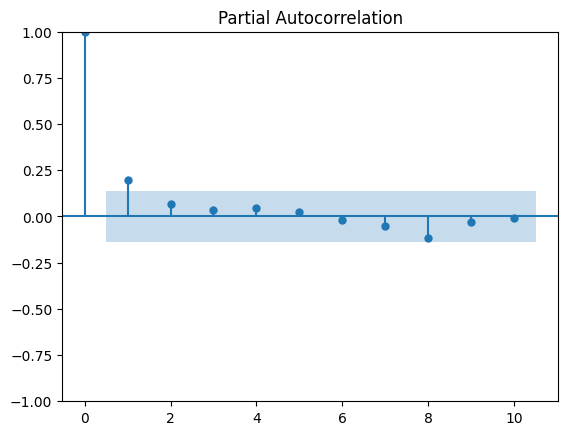

In [444]:
plot_pacf(diff_close, lags=10);


In [445]:
df_diff = pd.DataFrame({'diff_close': diff_close})
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train), len(test))

179 20


In [446]:
from itertools import product

ps = range(0, 3, 1)
qs = range(0, 3, 1)

order_list = list(product(ps, qs))
order_list

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [447]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []

    for order in order_list:
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [448]:
result_df = optimize_ARMA(train['diff_close'], order_list)
result_df

C:\envs\vertr\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 0)",-384.637591
1,"(2, 0)",-384.527411
2,"(1, 1)",-384.442223
3,"(0, 2)",-384.334455
4,"(2, 1)",-382.781478
5,"(0, 1)",-382.759321
6,"(1, 2)",-382.460387
7,"(2, 2)",-381.262180
8,"(0, 0)",-377.335186


In [458]:
model = SARIMAX(train['diff_close'], order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             diff_close   No. Observations:                  179
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 195.221
Date:                Sun, 26 Oct 2025   AIC                           -384.442
Time:                        19:40:08   BIC                           -374.880
Sample:                             0   HQIC                          -380.565
                                - 179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5951      0.250      2.378      0.017       0.105       1.085
ma.L1         -0.3927      0.284     -1.384      0.166      -0.949       0.163
sigma2         0.0066      0.001     12.923      0.0

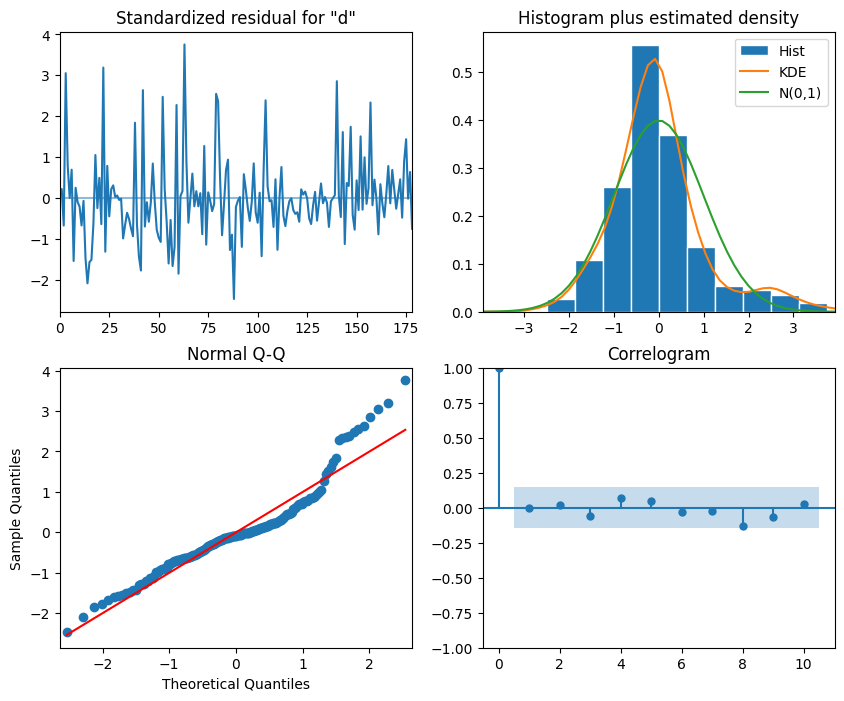

In [459]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [460]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid

stat = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)

stat['lb_pvalue'].mean()

np.float64(0.855642642897999)

In [452]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA

In [453]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

C:\Users\A\AppData\Local\Temp\ipykernel_642280\3552074462.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = pred_mean
C:\Users\A\AppData\Local\Temp\ipykernel_642280\3552074462.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_value'] = pred_last_value
C:\Users\A\AppData\Local\Temp\ipykernel_642280\3552074462.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,diff_close,pred_mean,pred_last_value,pred_ARMA
179,0.02,-0.000670,-0.04,0.000312
180,0.06,-0.000670,-0.04,0.000186
181,-0.16,-0.000221,0.06,0.013813
182,0.04,-0.000221,0.06,0.008358
183,0.04,-0.000874,0.04,-0.002880


In [454]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['diff_close'], test['pred_mean'])
mse_last = mean_squared_error(test['diff_close'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['diff_close'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

0.0067614200696869435 0.013620000000000465 0.007706940688804255


In [455]:
t = TRAIN_LEN + 1
df['pred_close'] = pd.Series()
df['pred_close'][t:] = df['close'].iloc[t] + test['pred_ARMA'].cumsum()

C:\Users\A\AppData\Local\Temp\ipykernel_642280\2825161181.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pred_close'][t:] = df['close'].iloc[t] + test['pred_ARMA'].cumsum()
C:\Users\A\AppData\Local\Temp\ipykernel_642280\2825161181.p

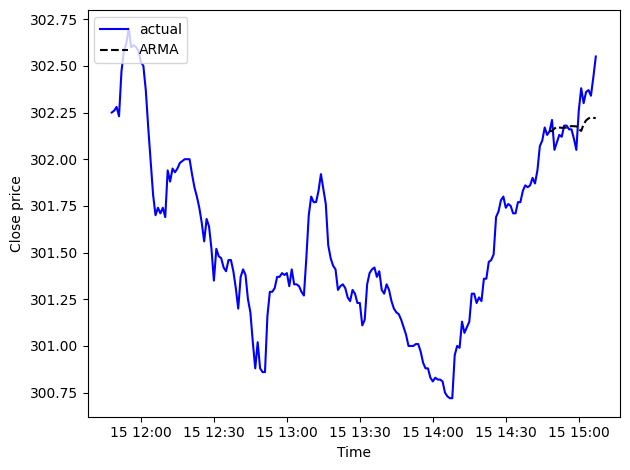

In [461]:
ig, ax = plt.subplots()

ax.plot(df['close'], 'b-', label='actual')
ax.plot(df['pred_close'], 'k--', label='ARMA')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Close price')

plt.tight_layout()

In [462]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['close'].iloc[t:], df['pred_close'].iloc[t:])

print(mae_MA_undiff)

0.09995038824606865
